# Final Project- Formal Methods in Robotics and AI

## Erik Bloomquist, Adam Benali, Rodrigo Bazan

Markov Decision Process constrained using LTL. Agent (Jerry) must never reach any hazard states (traps or Tom) while maximizing the probability of reaching a goal state (cheese). The run ends when either a hazard is reached or a cheese is reached. An optimal policy is computed using value iteration and displayed using arrows, representing the chosen action in each state. Success probabilities from each initial state are displayed. Tom's initial state is random uses a uniformely random movement policy.

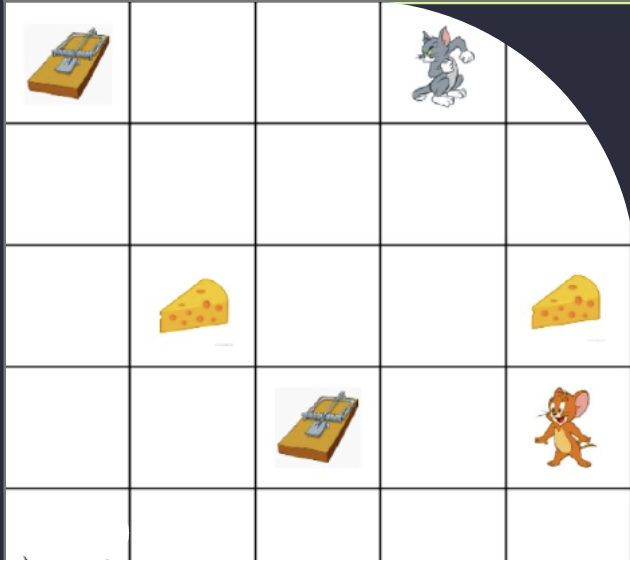

In [47]:
from IPython.display import Image
Image('TomJerryGrid.png')

In [38]:
import numpy as np

# -------------------------------------------------------------
# 1. Grid and indexing
# -------------------------------------------------------------
GRID_SIZE = 5
NUM_CELLS = GRID_SIZE * GRID_SIZE

def rc_to_pos(r, c):
    return r * GRID_SIZE + c

def pos_to_rc(pos):
    return divmod(pos, GRID_SIZE)

# 2. Environment layout: traps and cheese 
TRAP_CELLS = {
    rc_to_pos(0, 0),  # top-left in code coords (R_fig=4, C=0)
    rc_to_pos(3, 2),  # lower trap (R_fig=1, C=2)
}

CHEESE_CELLS = {
    rc_to_pos(2, 1),  # left cheese  (R_fig=2, C=1)
    rc_to_pos(2, 4),  # right cheese (R_fig=2, C=3)
}


is_trap = np.zeros(NUM_CELLS, dtype=bool)
is_cheese = np.zeros(NUM_CELLS, dtype=bool)
for p in TRAP_CELLS:
    is_trap[p] = True
for p in CHEESE_CELLS:
    is_cheese[p] = True

# 3. Actions and single-agent motion
NORTH, SOUTH, EAST, WEST = 0, 1, 2, 3
ACTIONS = [NORTH, SOUTH, EAST, WEST]
NUM_ACTIONS = len(ACTIONS)

ACTION_DELTAS = {
    NORTH: (-1, 0),
    SOUTH: ( 1, 0),
    EAST:  ( 0, 1),
    WEST:  ( 0,-1),
}

LEFT_OF = {
    NORTH: WEST,
    SOUTH: EAST,
    EAST:  NORTH,
    WEST:  SOUTH,
}
RIGHT_OF = {
    NORTH: EAST,
    SOUTH: WEST,
    EAST:  SOUTH,
    WEST:  NORTH,
}

def move_cell(pos, action):
    """Deterministic move; if off-grid, stay."""
    r, c = pos_to_rc(pos)
    dr, dc = ACTION_DELTAS[action]
    nr, nc = r + dr, c + dc
    if 0 <= nr < GRID_SIZE and 0 <= nc < GRID_SIZE:
        return rc_to_pos(nr, nc)
    else:
        return pos

def jerry_transition_probs(jerry_pos, action):
    """
    Return dict next_jerry_pos -> prob for Jerry:
    0.8 intended direction, 0.1 left, 0.1 right.
    """
    intended = action
    left = LEFT_OF[action]
    right = RIGHT_OF[action]
    moves = [intended, left, right]
    probs = [0.8, 0.1, 0.1]

    out = {}
    for a, p in zip(moves, probs):
        nxt = move_cell(jerry_pos, a)
        out[nxt] = out.get(nxt, 0.0) + p
    return out

def tom_transition_probs(tom_pos):
    """
    Tom: uniform random N,S,E,W.
    Return dict next_tom_pos -> prob.
    """
    out = {}
    for a in ACTIONS:
        nxt = move_cell(tom_pos, a)
        out[nxt] = out.get(nxt, 0.0) + 1.0 / NUM_ACTIONS
    return out

# 4. Joint state space (Jerry_pos, Tom_pos)
NUM_STATES = NUM_CELLS * NUM_CELLS

def encode_state(jerry_pos, tom_pos):
    return jerry_pos * NUM_CELLS + tom_pos

def decode_state(s):
    j = s // NUM_CELLS
    t = s % NUM_CELLS
    return j, t

def is_bad_state(j, t):
    return is_trap[j] or (j == t)

def is_goal_state(j, t):
    return is_cheese[j]

# 5. Transition for a given state & action (no big P tensor!)
def joint_transition(s, a):
    """
    For joint state index s and Jerry action a,
    return a dict: next_state_index -> prob.
    This computes transitions on the fly, using Jerry+Tom models.
    """
    j, t = decode_state(s)

    # If already terminal (goal or bad), stay put
    if is_goal_state(j, t) or is_bad_state(j, t):
        return {s: 1.0}

    out = {}
    j_probs = jerry_transition_probs(j, a)
    t_probs = tom_transition_probs(t)

    for j_next, pj in j_probs.items():
        for t_next, pt in t_probs.items():
            s_next = encode_state(j_next, t_next)
            out[s_next] = out.get(s_next, 0.0) + pj * pt
    return out

#6. Value iteration for reachability (on-the-fly transitions)

def value_iteration_reachability(tol=1e-8, max_iter=10_000):
    """
    Solve V(s) = max_a E[V(s')] for each state,
    with V(goal)=1, V(bad)=0.
    Returns:
        V: np.array shape (NUM_STATES,)
        policy: np.array shape (NUM_STATES,) with best action.
    """
    V = np.zeros(NUM_STATES, dtype=float)

    # Precompute terminal masks
    goal_mask = np.zeros(NUM_STATES, dtype=bool)
    bad_mask = np.zeros(NUM_STATES, dtype=bool)
    for s in range(NUM_STATES):
        j, t = decode_state(s)
        if is_goal_state(j, t):
            goal_mask[s] = True
        if is_bad_state(j, t):
            bad_mask[s] = True

    # Initialize boundary conditions
    V[goal_mask] = 1.0
    V[bad_mask] = 0.0

    for it in range(max_iter):
        delta = 0.0
        V_old = V.copy()

        for s in range(NUM_STATES):
            if goal_mask[s] or bad_mask[s]:
                # Terminal; keep fixed
                continue

            best_q = -1.0
            for a in ACTIONS:
                q = 0.0
                for s_next, p in joint_transition(s, a).items():
                    q += p * V_old[s_next]
                if q > best_q:
                    best_q = q
            V[s] = best_q
            delta = max(delta, abs(V[s] - V_old[s]))

        print(f"Iter {it}, delta = {delta:.3e}")
        if delta < tol:
            print(f"Converged in {it} iterations.")
            break

    # Extract greedy policy
    policy = np.zeros(NUM_STATES, dtype=int)
    for s in range(NUM_STATES):
        if goal_mask[s] or bad_mask[s]:
            policy[s] = -1  # no action needed
            continue
        best_a = 0
        best_q = -1.0
        for a in ACTIONS:
            q = 0.0
            for s_next, p in joint_transition(s, a).items():
                q += p * V[s_next]
            if q > best_q:
                best_q = q
                best_a = a
        policy[s] = best_a

    return V, policy

# 7. Aggregate over Tom's initial position
def jerry_value_marginal_over_tom(V, tom_initial_dist=None):
    if tom_initial_dist is None:
        tom_initial_dist = np.ones(NUM_CELLS) / NUM_CELLS
    tom_initial_dist = np.asarray(tom_initial_dist)
    assert tom_initial_dist.shape == (NUM_CELLS,)
    assert np.allclose(tom_initial_dist.sum(), 1.0)

    jerry_vals = np.zeros(NUM_CELLS)
    for j in range(NUM_CELLS):
        val = 0.0
        for t in range(NUM_CELLS):
            s = encode_state(j, t)
            val += tom_initial_dist[t] * V[s]
        jerry_vals[j] = val
    return jerry_vals.reshape(GRID_SIZE, GRID_SIZE)

# 8. Run experiment
if __name__ == "__main__":
    print("Running value iteration (on-the-fly transitions, no big matrices)...")
    V, policy = value_iteration_reachability()

    print("Value function length:", len(V))
    print("Policy length:", len(policy))

    # Example: specific initial state
    jerry_start = rc_to_pos(4, 0)
    tom_start = rc_to_pos(0, 2)
    s0 = encode_state(jerry_start, tom_start)
    print(f"Value at initial state (Jerry={jerry_start}, Tom={tom_start}): {V[s0]:.4f}")

    # Aggregate over random Tom initial position
    grid_vals = jerry_value_marginal_over_tom(V)
    np.set_printoptions(precision=3, suppress=True)
    print("\nJerry's aggregated success probabilities over starting positions (5x5 grid):")
    print(grid_vals)


Running value iteration (on-the-fly transitions, no big matrices)...
Iter 0, delta = 8.000e-01
Iter 1, delta = 7.200e-01
Iter 2, delta = 6.400e-01
Iter 3, delta = 2.833e-01
Iter 4, delta = 1.632e-01
Iter 5, delta = 1.249e-01
Iter 6, delta = 1.050e-01
Iter 7, delta = 4.589e-02
Iter 8, delta = 3.180e-02
Iter 9, delta = 2.360e-02
Iter 10, delta = 1.952e-02
Iter 11, delta = 1.680e-02
Iter 12, delta = 1.401e-02
Iter 13, delta = 1.172e-02
Iter 14, delta = 9.563e-03
Iter 15, delta = 7.836e-03
Iter 16, delta = 6.322e-03
Iter 17, delta = 5.113e-03
Iter 18, delta = 4.095e-03
Iter 19, delta = 3.299e-03
Iter 20, delta = 2.642e-03
Iter 21, delta = 2.124e-03
Iter 22, delta = 1.706e-03
Iter 23, delta = 1.378e-03
Iter 24, delta = 1.112e-03
Iter 25, delta = 9.105e-04
Iter 26, delta = 7.476e-04
Iter 27, delta = 6.148e-04
Iter 28, delta = 5.056e-04
Iter 29, delta = 4.161e-04
Iter 30, delta = 3.425e-04
Iter 31, delta = 2.821e-04
Iter 32, delta = 2.323e-04
Iter 33, delta = 1.914e-04
Iter 34, delta = 1.577e

In [40]:
# After value_iteration_reachability finishes:
grid_vals = jerry_value_marginal_over_tom(V)

# Print to console
np.set_printoptions(precision=3, suppress=True)
print("\nJerry's aggregated success probabilities over starting positions (5x5 grid):")
print(grid_vals)

# Save as CSV
np.savetxt("jerry_success_grid_randomTom.csv", grid_vals, delimiter=",", fmt="%.4f")
print("Saved heatmap data to jerry_success_grid_randomTom.csv")



Jerry's aggregated success probabilities over starting positions (5x5 grid):
[[0.    0.929 0.947 0.949 0.947]
 [0.93  0.95  0.949 0.951 0.953]
 [0.949 0.96  0.934 0.95  0.96 ]
 [0.94  0.927 0.    0.929 0.947]
 [0.932 0.929 0.892 0.932 0.937]]
Saved heatmap data to jerry_success_grid_randomTom.csv


In [41]:
def jerry_policy_from_joint_ascii(V, tom_initial_dist=None):
    """
    Compute an aggregated policy over Jerry positions only,
    by averaging over Tom's initial position distribution.

    Returns:
        arrows_grid_code: 5x5 array of unicode arrows using code coordinates
                          (row 0 = top).
        arrows_grid_figure: 5x5 array flipped vertically so that
                            row 0 is at the bottom, matching the slide
                            convention (R:0 at bottom).
    """
    if tom_initial_dist is None:
        tom_initial_dist = np.ones(NUM_CELLS) / NUM_CELLS
    tom_initial_dist = np.asarray(tom_initial_dist)
    assert tom_initial_dist.shape == (NUM_CELLS,)
    assert np.allclose(tom_initial_dist.sum(), 1.0)

    # Map action index -> arrow character
    arrow_for_action = {
        NORTH: "↑",
        SOUTH: "↓",
        EAST:  "→",
        WEST:  "←",
    }

    arrows_code = np.empty((GRID_SIZE, GRID_SIZE), dtype=object)

    # For each Jerry cell j, pick the action maximizing expected next-state value
    for j in range(NUM_CELLS):
        best_a = NORTH
        best_q = -1.0

        for a in ACTIONS:
            q = 0.0
            # Average over Tom's initial position
            for t in range(NUM_CELLS):
                s = encode_state(j, t)
                trans = joint_transition(s, a)
                for s_next, p in trans.items():
                    q += tom_initial_dist[t] * p * V[s_next]

            if q > best_q:
                best_q = q
                best_a = a

        r, c = pos_to_rc(j)           # code coords: row 0 = TOP
        arrows_code[r, c] = arrow_for_action[best_a]

    # Flip vertically so row 0 is at the BOTTOM (matches slide R:0)
    arrows_figure = np.flipud(arrows_code)

    return arrows_code, arrows_figure


In [42]:
arrows_code, arrows_figure = jerry_policy_from_joint_ascii(V)

print("\nJerry's aggregated optimal directions (5x5 grid):")
for r in range(GRID_SIZE):
    print(" ".join(arrows_code[r]))



Jerry's aggregated optimal directions (5x5 grid):
↑ → → ↓ →
↓ ↓ → → ↓
→ ↑ ↑ → ↑
↑ ← ↑ → ↑
← ← ↓ → →
